In [1]:
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A
from itertools import chain
import textdistance
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
import random


In [2]:
adapter_string = "sqlite:obo:envo"

In [3]:
target_labels = ["soil"]

In [4]:
output_file = "discover_excludable_soils.tsv"

In [5]:
reasonable_relations = [
    'adjacent to',
    'composed primarily of',
    'has part',
    'located in',
    'part of',
]

# this excludes relations in which one participant must be a quality, process, etc.

In [6]:
adapter = get_adapter(adapter_string)

In [7]:
biomes = set()

curies = adapter.basic_search("biome")
for curie in curies:
    descendants = adapter.descendants(curie, predicates=[IS_A])
    for d in descendants:
        biomes.add(d)

In [8]:
environmental_materials = set()

curies = adapter.basic_search("environmental material")
for curie in curies:
    descendants = adapter.descendants(curie, predicates=[IS_A])
    for d in descendants:
        environmental_materials.add(d)

In [9]:
material_entities = set()

curies = adapter.basic_search("material entity")
for curie in curies:
    descendants = adapter.descendants(curie, predicates=[IS_A])
    for d in descendants:
        material_entities.add(d)

In [10]:
# reasonable_others = material_entities - biomes.union(environmental_materials)

reasonable_others = material_entities - environmental_materials # actually, let's also pull out soils whose differentia can be expressed in the env_broad_scale

# mangrove biome soil

In [11]:
targets = set()

In [12]:
for current_label in target_labels:
    for class_id in adapter.basic_search(current_label):
        descendants = adapter.descendants(class_id, predicates=[IS_A])
        for d in descendants:
            targets.add(d)


In [13]:
up_rels = adapter.relationships(targets)

In [14]:
down_rels = adapter.relationships(objects=targets)

In [15]:
rels_gen = chain(up_rels, down_rels)

In [16]:
rels_list = []

In [17]:
preds_count = {}

In [18]:
differentiated_targets = targets.copy()

differentiated_targets.remove("ENVO:00001998")

In [19]:
for rel in rels_gen:
    s, p, o = rel
    p_lab_or_id = adapter.label(p) if adapter.label(p) is not None else p
    inner_dict = {
        "s": s,
        "s_is_soil": s in differentiated_targets,
        "s_is_reasonable_other": s in reasonable_others,
        "slab": adapter.label(s),
        "p": p,
        "plab": adapter.label(p),
        "p_lab_or_id": p_lab_or_id,
        'relation_is_reasonable': p_lab_or_id in reasonable_relations,
        "o": o,
        "o_is_soil": o in differentiated_targets,
        "o_is_reasonable_other": o in reasonable_others,
        "olab": adapter.label(o),
        "slab_olab_cosine": textdistance.cosine(adapter.label(s), adapter.label(o))
    }
    if inner_dict['s_is_soil'] and not inner_dict['o_is_soil']:
        inner_dict['sole_soil'] = inner_dict['slab']
    if inner_dict['o_is_soil'] and not inner_dict['s_is_soil']:
        inner_dict['sole_soil'] = inner_dict['olab']

    if inner_dict['s_is_reasonable_other'] and not inner_dict['o_is_reasonable_other']:
        inner_dict['sole_reasonable_other'] = inner_dict['slab']
    if inner_dict['o_is_reasonable_other'] and not inner_dict['s_is_reasonable_other']:
        inner_dict['sole_reasonable_other'] = inner_dict['olab']

    if inner_dict['p_lab_or_id'] in preds_count:
        preds_count[inner_dict['p_lab_or_id']] += 1
    else:
        preds_count[inner_dict['p_lab_or_id']] = 1

    rels_list.append(inner_dict)

In [20]:
rels_frame = pd.DataFrame(rels_list)

In [21]:
rels_frame.to_csv(output_file, sep="\t", index=False)

In [22]:
reasonable_frame = rels_frame[rels_frame['relation_is_reasonable']]
# filter out rows with null/NA values
reasonable_frame = reasonable_frame.dropna()

In [23]:
reasonable_frame

,s,s_is_soil,s_is_reasonable_other,slab,p,plab,p_lab_or_id,relation_is_reasonable,o,o_is_soil,o_is_reasonable_other,olab,slab_olab_cosine,sole_reasonable_other,sole_soil
51,ENVO:00002259,True,False,agricultural soil,BFO:0000050,part of,part of,True,ENVO:00000077,False,True,agricultural ecosystem,0.775632,agricultural ecosystem,agricultural soil
53,ENVO:00002260,True,False,dune soil,BFO:0000050,part of,part of,True,ENVO:00000170,False,True,dune,0.666667,dune,dune soil
55,ENVO:00002261,True,False,forest soil,RO:0001025,located in,located in,True,ENVO:00000111,False,True,forested area,0.585369,forested area,forest soil
59,ENVO:00002263,True,False,garden soil,BFO:0000050,part of,part of,True,ENVO:00000011,False,True,garden,0.738549,garden,garden soil
60,ENVO:00002263,True,False,garden soil,RO:0001025,located in,located in,True,ENVO:00000011,False,True,garden,0.738549,garden,garden soil
64,ENVO:00002275,True,False,technosol,BFO:0000050,part of,part of,True,ENVO:01000983,False,True,technosphere,0.673575,technosphere,technosol
103,ENVO:00005740,True,False,paddy field soil,BFO:0000050,part of,part of,True,ENVO:00000297,False,True,paddy field,0.829156,paddy field,paddy field soil
108,ENVO:00005743,True,False,roadside soil,RO:0001025,located in,located in,True,ENVO:01000447,False,True,roadside,0.784465,roadside,roadside soil
110,ENVO:00005744,True,False,allotment garden soil,BFO:0000050,part of,part of,True,ENVO:00005745,False,True,allotment garden,0.872872,allotment garden,allotment garden soil
112,ENVO:00005746,True,False,savanna soil,RO:0001025,located in,located in,True,ENVO:00000261,False,True,savanna,0.763763,savanna,savanna soil


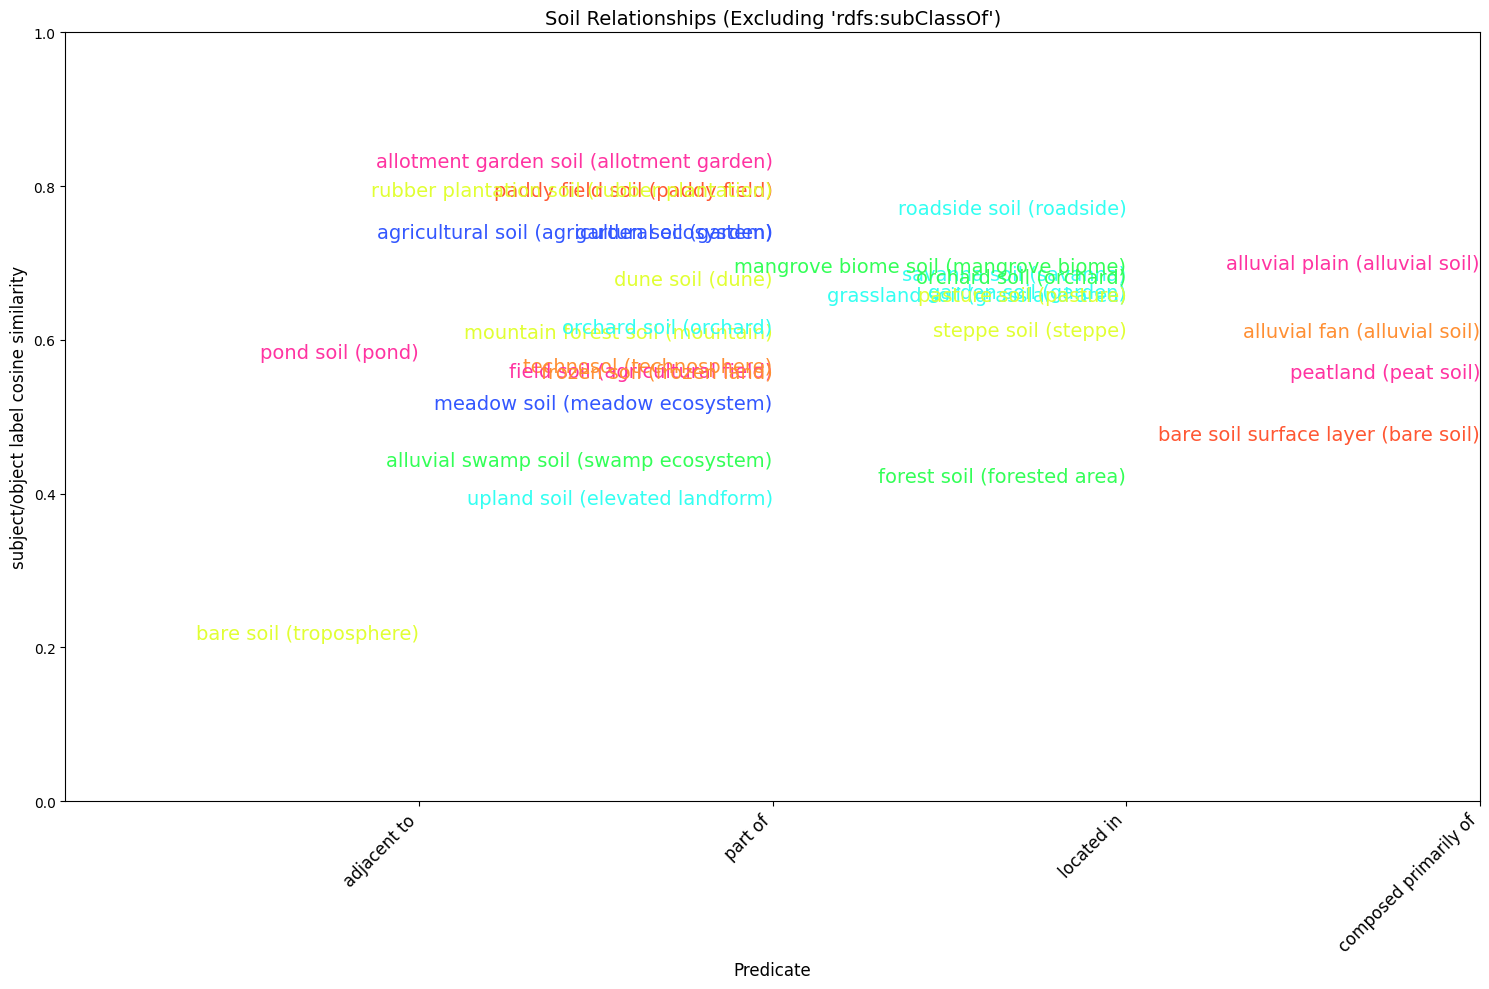

In [24]:

reasonable_lod = reasonable_frame.to_dict(orient='records')

# Extract unique groups from 'p_lab_or_id' and map each one to an x-axis position
groups = {item['p_lab_or_id'] for item in reasonable_lod}
group_positions = {group: idx + 1 for idx, group in
                   enumerate(groups)}  # Assign positions for each unique 'p_lab_or_id' group


# Helper function to wrap labels
def wrap_label(label, width=15):
    return "\n".join(textwrap.wrap(label, width))


# Define a set of colors to choose from (optional)
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#FF8F33', '#33FFF2', '#E1FF33']

# Adjust the figure size and font size
plt.figure(figsize=(15, 10))

# Plot each label with more random jitter and random color
for item in reasonable_lod:
    x = group_positions[item['p_lab_or_id']]
    y = item['slab_olab_cosine']
    label = f"{item['slab']} ({item['olab']})"
    wrapped_label = wrap_label(label, width=50)

    # Add increased random jitter to the label position
    # x_jitter = random.uniform(-0.3, 0.3)  # Larger random jitter in x-axis
    y_jitter = random.uniform(-0.2, 0.0)  # Larger random jitter in y-axis

    # Select a random color for the label
    color = random.choice(colors)  # Alternatively, use color = (random.random(), random.random(), random.random())

    # # Plot the label with random color
    # plt.text(x + x_jitter, y + y_jitter, wrapped_label, ha='center', va='bottom', fontsize=8, color=color)
    plt.text(x, y + y_jitter , wrapped_label, ha='right', va='bottom', fontsize=14, color=color)

# Increase x-tick label size and rotate
plt.xticks(ticks=list(group_positions.values()), labels=list(group_positions.keys()), rotation=45, ha='right',
           fontsize=12)

# Configure other plot aesthetics
plt.xlabel("Predicate", fontsize=12)
plt.ylabel("subject/object label cosine similarity", fontsize=12)
plt.title("Soil Relationships (Excluding 'rdfs:subClassOf')", fontsize=14)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()